In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')
import astropy.stats as stats
from scipy.signal import savgol_filter

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
FITSfiles = sorted(glob.glob(f"/home/fortino/GPRSolutions/zone134/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone133/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/zone132/GPR.??????.?RC.fits"))
FITSfiles += sorted(glob.glob(f"/home/fortino/GPRSolutions/eris/GPR.??????.?RC.fits"))
print(len(FITSfiles))

343


In [3]:
%%time
AP = plotGPR.AggregatePlots(FITSfiles)
AP.calcVals()
AP.calcArrs()

CPU times: user 1h 32min 6s, sys: 18min 24s, total: 1h 50min 31s
Wall time: 1h 51min 18s


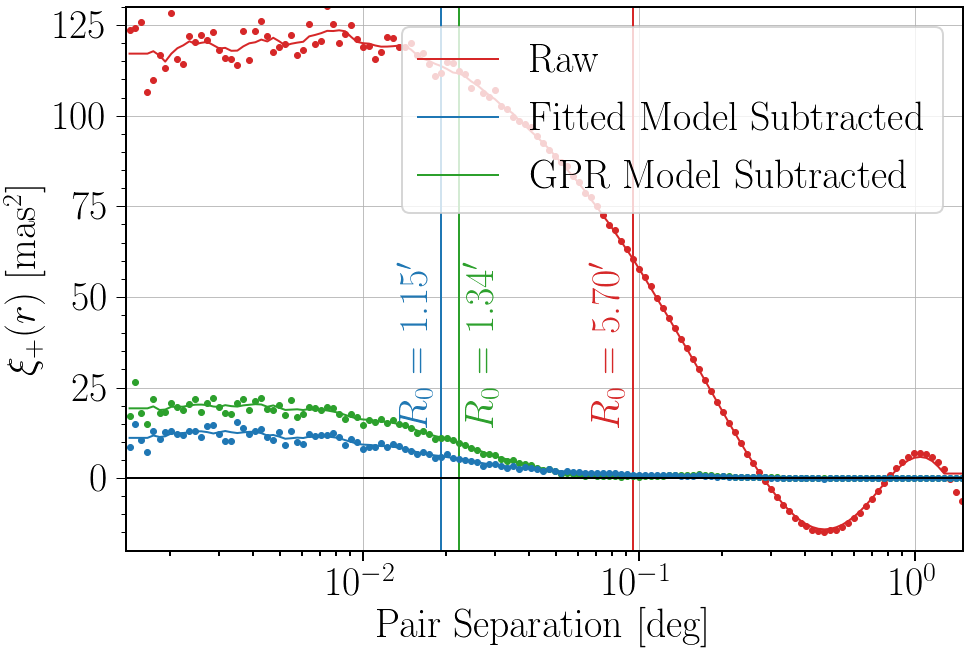

In [51]:
# Remove legend big annotations. Same with R0 (vertical text along line)

def avgxi(
    AP,
    passband,
    rMax=0.5*u.arcmin,
    usexi0=False,
    normalize=None,
    window_length=25, polyorder=0,
    ylim=(None, None),
    save=None
        ):
    
    fs = 40
    
    r = []
    xiplus_raw = []
    xiplus_GPR = []
    xi0_raw = []
    xi0_GPR = []
    xiplus_GPR_fC = []
    xi0_GPR_fC = []
    for band in plotGPR.DES_PASSBANDS:

        # Check if the current band in the loop is one of the bands in the list passband.
        if passband is not None:
            if band not in passband:
                continue

        # If there are no exposures for that band in AP, then skip it.
        if len(AP.expNums[band]) == 0:
            continue
            
        r.extend(AP.r[band])
        xiplus_raw.extend(AP.xiplus_raw[band])
        xiplus_GPR.extend(AP.xiplus_GPR[band])
        xi0_raw.extend(AP.xi0_raw[band])
        xi0_GPR.extend(AP.xi0_GPR[band])
        
        xiplus_GPR_fC.extend(AP.xiplus_GPR_fC[band])
        xi0_GPR_fC.extend(AP.xi0_GPR_fC[band])


    plt.figure(figsize=(15, 10))

    r = np.nanmean(np.vstack(r), axis=0)
    xiplus_raw = np.nanmean(np.vstack(xiplus_raw), axis=0)
    xiplus_GPR = np.nanmean(np.vstack(xiplus_GPR), axis=0)
    xiplus_GPR_fC = np.nanmean(np.vstack(xiplus_GPR_fC), axis=0)

    if usexi0:
        xi0_raw = np.nanmean(xi0_raw)
        xi0_GPR = np.nanmean(xi0_GPR)
        xi0_GPR_fC = np.nanmean(xi0_GPR_fC)
    else:
        xi0_raw = np.nanmean(xiplus_raw[r < (rMax).to(u.deg).value])
        xi0_GPR = np.nanmean(xiplus_GPR[r < (rMax).to(u.deg).value])
        xi0_GPR_fC = np.nanmean(xiplus_GPR_fC[r < (rMax).to(u.deg).value])

    if normalize:
        xiplus_raw /= xi0_raw
        xi0_raw /= xi0_raw
        
        xiplus_GPR /= xi0_GPR
        xi0_GPR /= xi0_GPR

        xiplus_GPR_fC /= xi0_GPR_fC
        xi0_GPR_fC /= xi0_GPR_fC
        
        label = r"/$\xi_0$"
    else:
        label = ""

    # Calculate and plot the smoothed correlation function.
    smooth_xiplus_raw = savgol_filter(xiplus_raw, window_length, polyorder)
    smooth_xiplus_GPR = savgol_filter(xiplus_GPR, window_length, polyorder)
    smooth_xiplus_GPR_fC = savgol_filter(xiplus_GPR_fC, window_length, polyorder)
    plt.semilogx(r, smooth_xiplus_raw, color="tab:red", ls="-")
    plt.semilogx(r, smooth_xiplus_GPR, color="tab:blue", ls="-")
    plt.semilogx(r, smooth_xiplus_GPR_fC, color="tab:green", ls="-")

    # Calculate and plot the verticle lines at the correlation length.
    r0_raw = r[np.abs(smooth_xiplus_raw - xi0_raw/2).argmin()]
    r0_GPR = r[np.abs(smooth_xiplus_GPR - xi0_GPR/2).argmin()]
    r0_GPR_fC = r[np.abs(smooth_xiplus_GPR_fC - xi0_GPR_fC/2).argmin()]
    plt.axvline(x=r0_raw, c="tab:red", ls="-", label=f"Raw")
    plt.axvline(x=r0_GPR, c="tab:blue", ls="-", label=f"Fitted Model Subtracted")
    plt.axvline(x=r0_GPR_fC, c="tab:green", ls="-", label=f"GPR Model Subtracted")

    # Plot the actual correlation function.
    plt.semilogx(r, xiplus_raw, color="tab:red", ls="", marker="o")
    plt.semilogx(r, xiplus_GPR_fC, color="tab:green", ls="", marker="o")
    plt.semilogx(r, xiplus_GPR, color="tab:blue", ls="", marker="o")

    plt.axhline(y=0, color="k")

    plt.xlim(((5*u.arcsec).to(u.deg).value, (1.5*u.deg).to(u.deg).value))
    plt.ylim(ylim)
    
    plt.tick_params(axis='both', which='major', labelsize=fs)

    plt.xlabel("Pair Separation [deg]", fontsize=fs)
    plt.ylabel(r"$\xi_+(r)$" + f"{label}" + " [mas$^2$]", fontsize=fs)
    
    kwargs = {
        "rotation": "vertical",
        "va": "top",
        "fontsize": fs
    }
    
    r0_raw_str = r"$R_0$ = " + f"{(r0_raw*u.deg).to(u.arcmin).value:.2f}" + r"$^\prime$"
    r0_GPR_fC_str = r"$R_0$ = " + f"{(r0_GPR_fC*u.deg).to(u.arcmin).value:.2f}" + r"$^\prime$"
    r0_GPR_str = r"$R_0$ = " + f"{(r0_GPR*u.deg).to(u.arcmin).value:.2f}" + r"$^\prime$"
    
    plt.annotate(r0_raw_str, (r0_raw, 60), ha="right", color="tab:red", **kwargs)
    plt.annotate(r0_GPR_fC_str, (1.1*r0_GPR_fC, 60), ha="left", color="tab:green", **kwargs)
    plt.annotate(r0_GPR_str, (r0_GPR, 60), ha="right", color="tab:blue", **kwargs)

    plt.grid()
    plt.legend(loc="upper right", fontsize=fs)

    if save is not None:
        plt.savefig(save)

    plt.show()
    
avgxi(AP, ["r", "i", "z"], normalize=False, ylim=(-20, 130), window_length=7, save="/home/fortino/avgxi.pdf")